# Exploratory Data Analysis and Data Preprocessing

This notebook performs exploratory data analysis on the CFPB complaint dataset and prepares it for the RAG pipeline.

## Objectives
1. Load the CFPB complaint dataset
2. Perform initial EDA to understand the data structure and quality
3. Filter the dataset to include only the five specified products
4. Clean the text narratives to improve embedding quality
5. Save the cleaned and filtered dataset


In [1]:
# Setup
# Import necessary libraries and set configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from pathlib import Path
import warnings
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create project directories if they don't exist
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load project configuration
config_path = Path('../.vscode/settings.json')
if config_path.exists():
    with open(config_path, 'r') as f:
        config = json.load(f)
    print("VS Code configuration loaded.")
else:
    print("VS Code configuration not found. Using default settings.")
    
# Define the products of interest for the project
PRODUCTS_OF_INTEREST = [
    "Credit card", 
    "Personal loan", 
    "Buy Now, Pay Later (BNPL)", 
    "Savings account", 
    "Money transfers"
]

print("Setup complete.")


VS Code configuration loaded.
Setup complete.


## 1. Load the CFPB Complaint Dataset

In this section, we'll load the CFPB complaint dataset from our local data directory. The dataset contains information about consumer complaints regarding financial products and services.

The dataset is stored in `data/raw/complaints.csv` and contains the full CFPB complaint database that we'll use for our analysis.


In [2]:
# Load the actual CFPB complaint dataset
print("Loading the CFPB complaint dataset...")

# Define the data paths
raw_data_path = Path('../data/raw')
processed_data_path = Path('../data/processed')
complaints_file = raw_data_path / 'complaints.csv'

# Load the dataset
df = pd.read_csv(complaints_file)

# Display basic information about the dataset
print("\nDataset loaded successfully!")
print(f"Total number of complaints: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")
print("\nColumns in the dataset:")
for col in df.columns:
    print(f"- {col}")

# Display the first few rows
print("\nFirst few rows of the dataset:")
df.head()


Loading the CFPB complaint dataset...

Dataset loaded successfully!
Total number of complaints: 9,609,797
Number of columns: 18

Columns in the dataset:
- Date received
- Product
- Sub-product
- Issue
- Sub-issue
- Consumer complaint narrative
- Company public response
- Company
- State
- ZIP code
- Tags
- Consumer consent provided?
- Submitted via
- Date sent to company
- Company response to consumer
- Timely response?
- Consumer disputed?
- Complaint ID

First few rows of the dataset:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


## 2. Exploratory Data Analysis

Now that we have loaded the data, let's explore it to understand its structure and quality.


In [4]:
# 2.1 Basic Data Exploration

# Check the dataset info
print("Dataset Information:")
df.info()

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

# Summary statistics for numeric columns
print("\nSummary Statistics:")
df.describe().T

# Check unique values for categorical columns
categorical_columns = ['Product', 'Issue', 'Company', 'State', 'Company response to consumer']
for col in categorical_columns:
    unique_values = df[col].nunique()
    print(f"\n{col}: {unique_values} unique values")
    if unique_values < 20:  # Only show all values if there are fewer than 20
        print(df[col].value_counts().head(10))


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(1

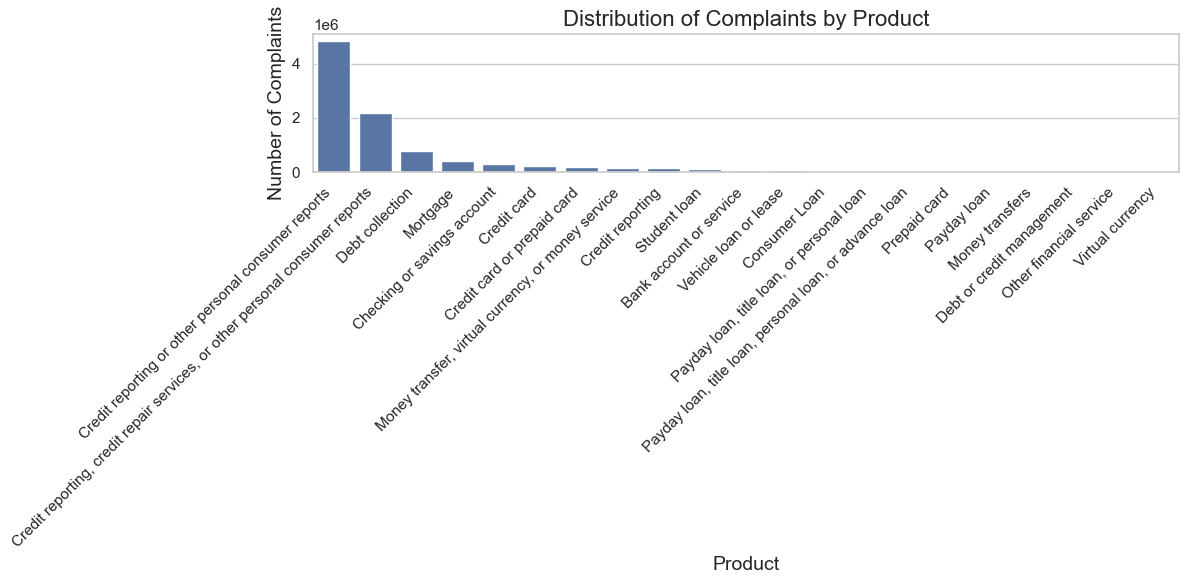

Percentage of complaints by product:
Credit reporting or other personal consumer reports: 50.31%
Credit reporting, credit repair services, or other personal consumer reports: 22.52%
Debt collection: 8.32%
Mortgage: 4.39%
Checking or savings account: 3.03%
Credit card: 2.36%
Credit card or prepaid card: 2.15%
Money transfer, virtual currency, or money service: 1.51%
Credit reporting: 1.46%
Student loan: 1.14%
Bank account or service: 0.90%
Vehicle loan or lease: 0.76%
Consumer Loan: 0.33%
Payday loan, title loan, or personal loan: 0.32%
Payday loan, title loan, personal loan, or advance loan: 0.17%
Prepaid card: 0.16%
Payday loan: 0.06%
Money transfers: 0.06%
Debt or credit management: 0.05%
Other financial service: 0.01%
Virtual currency: 0.00%

Products of interest present in the dataset:
- Credit card
- Money transfers

Products of interest NOT present in the dataset:
- Savings account
- Buy Now, Pay Later (BNPL)
- Personal loan


In [5]:
# 2.2 Analyze the distribution of complaints across different Products

# Create a bar plot of product distribution
plt.figure(figsize=(12, 6))
product_counts = df['Product'].value_counts()
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.title('Distribution of Complaints by Product', fontsize=16)
plt.xlabel('Product', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the percentage of complaints for each product
product_percentage = (product_counts / product_counts.sum()) * 100
print("Percentage of complaints by product:")
for product, percentage in product_percentage.items():
    print(f"{product}: {percentage:.2f}%")

# Check which of our products of interest are present in the dataset
products_present = set(df['Product'].unique())
products_of_interest_set = set(PRODUCTS_OF_INTEREST)
print("\nProducts of interest present in the dataset:")
for product in products_of_interest_set.intersection(products_present):
    print(f"- {product}")
print("\nProducts of interest NOT present in the dataset:")
for product in products_of_interest_set - products_present:
    print(f"- {product}")

# Remove the mock data check since we're using real data


Statistics on narrative length (word count):
count    9.609797e+06
mean     5.446667e+01
std      1.497672e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_word_count, dtype: float64


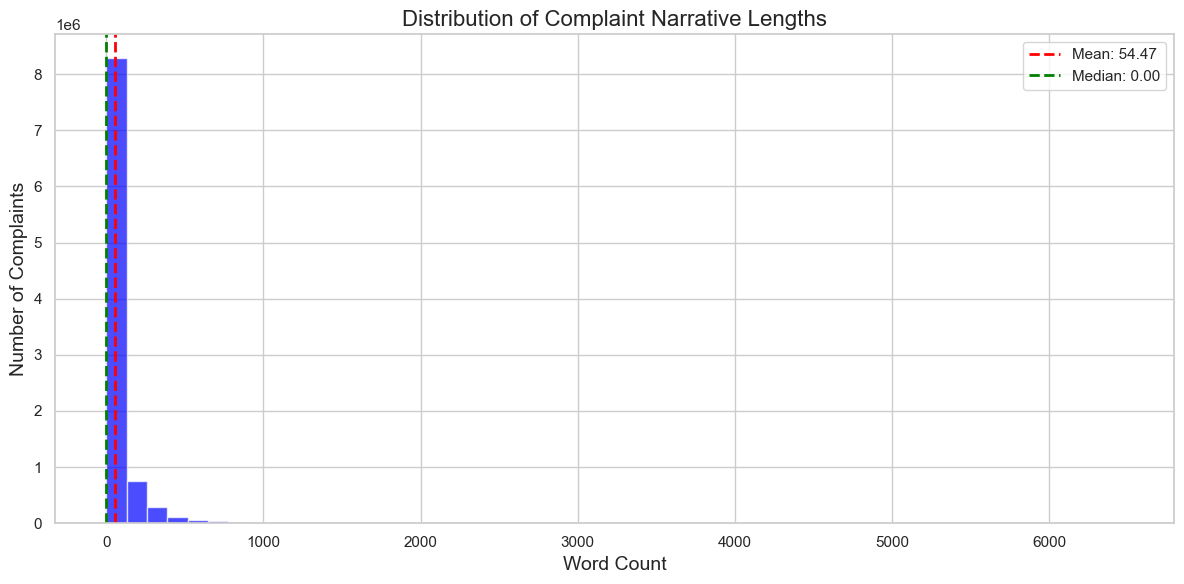


Number of very short narratives (< 10 words): 6650979
Number of very long narratives (> 2x the 75th percentile): 1678274

Complaints with narratives: 2980756 (31.02%)
Complaints without narratives: 6629041 (68.98%)


In [7]:
# 2.3 Analyze the length (word count) of the Consumer complaint narratives

# Function to count words in text
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    return 0

# Add a column with the word count for each narrative
df['narrative_word_count'] = df['Consumer complaint narrative'].apply(count_words)

# Calculate statistics on narrative length
narrative_length_stats = df['narrative_word_count'].describe()
print("Statistics on narrative length (word count):")
print(narrative_length_stats)

# Plot the distribution of narrative lengths
plt.figure(figsize=(12, 6))
plt.hist(df['narrative_word_count'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Complaint Narrative Lengths', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.axvline(narrative_length_stats['mean'], color='red', linestyle='dashed', linewidth=2, label=f"Mean: {narrative_length_stats['mean']:.2f}")
plt.axvline(narrative_length_stats['50%'], color='green', linestyle='dashed', linewidth=2, label=f"Median: {narrative_length_stats['50%']:.2f}")
plt.legend()
plt.tight_layout()
plt.show()

# Identify very short and very long narratives
very_short = df[df['narrative_word_count'] < 10]
very_long = df[df['narrative_word_count'] > narrative_length_stats['75%'] * 2]

print(f"\nNumber of very short narratives (< 10 words): {len(very_short)}")
print(f"Number of very long narratives (> 2x the 75th percentile): {len(very_long)}")

# Identify complaints with and without narratives
with_narrative = df[df['narrative_word_count'] > 0]
without_narrative = df[df['narrative_word_count'] == 0]

print(f"\nComplaints with narratives: {len(with_narrative)} ({len(with_narrative) / len(df) * 100:.2f}%)")
print(f"Complaints without narratives: {len(without_narrative)} ({len(without_narrative) / len(df) * 100:.2f}%)")


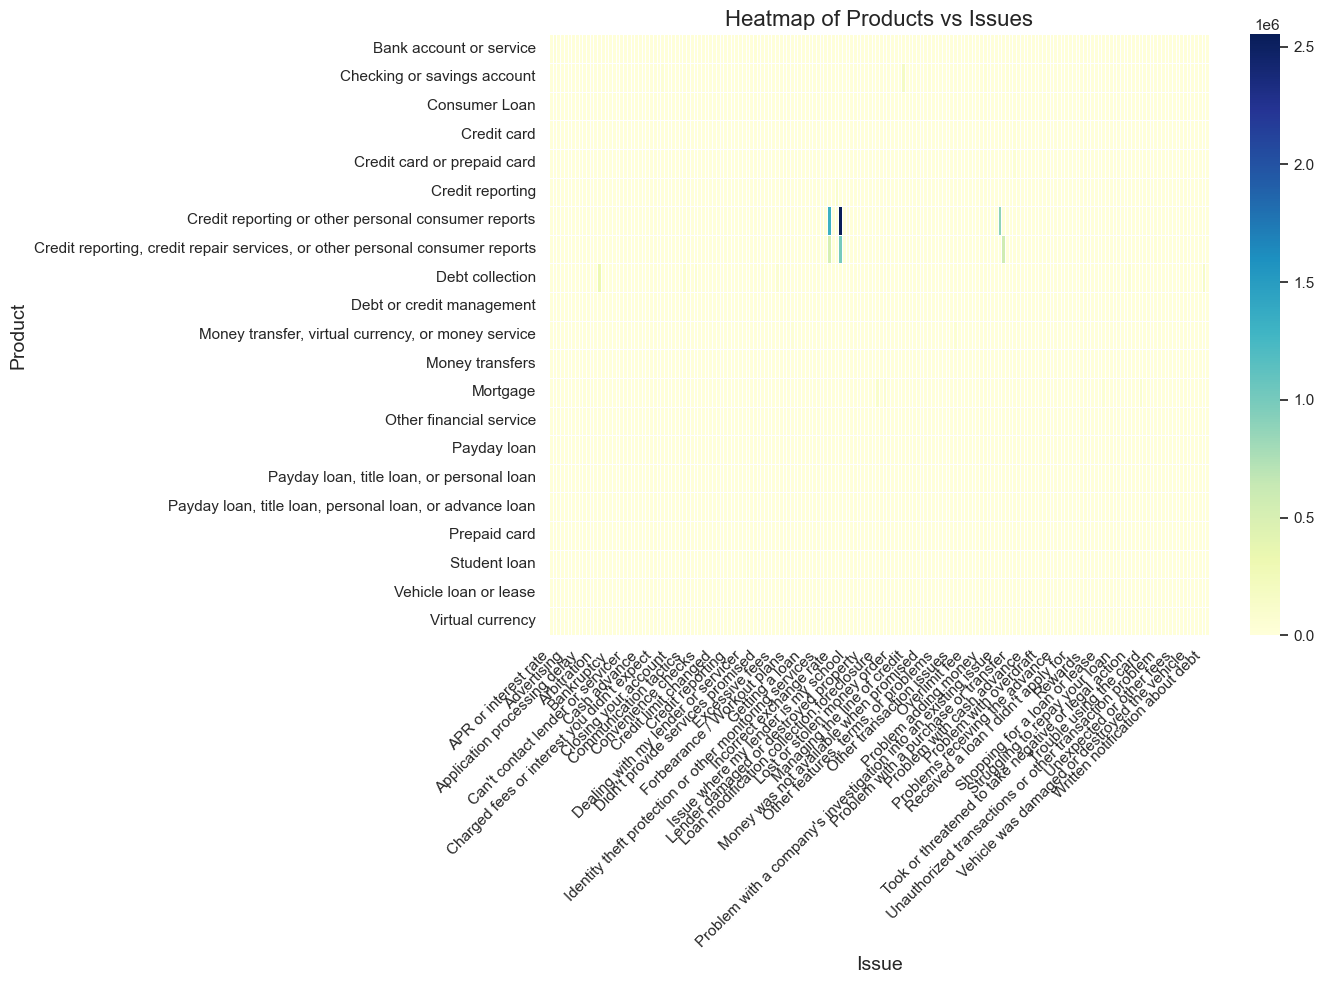

Top 3 issues for each product of interest:

Credit card:
  - Problem with a purchase shown on your statement: 26734 complaints (11.79%)
  - Incorrect information on your report: 20211 complaints (8.92%)
  - Problem with a company's investigation into an existing problem: 20077 complaints (8.86%)

Money transfers:
  - Fraud or scam: 1893 complaints (35.36%)
  - Other transaction issues: 1487 complaints (27.77%)
  - Money was not available when promised: 997 complaints (18.62%)


In [8]:
# 2.4 Analyze the relationship between products and issues

# Create a heatmap of products vs issues
plt.figure(figsize=(14, 10))
product_issue_counts = pd.crosstab(df['Product'], df['Issue'])
sns.heatmap(product_issue_counts, cmap='YlGnBu', annot=False, fmt='d', linewidths=.5)
plt.title('Heatmap of Products vs Issues', fontsize=16)
plt.xlabel('Issue', fontsize=14)
plt.ylabel('Product', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# For each product of interest, show the top 3 issues
print("Top 3 issues for each product of interest:")
for product in set(PRODUCTS_OF_INTEREST).intersection(products_present):
    product_df = df[df['Product'] == product]
    top_issues = product_df['Issue'].value_counts().head(3)
    print(f"\n{product}:")
    for issue, count in top_issues.items():
        print(f"  - {issue}: {count} complaints ({count/len(product_df)*100:.2f}%)")


## 3. Filter the Dataset

Now that we understand the data, let's filter it to meet the project's requirements:
1. Include only records for the five specified products
2. Remove any records with empty Consumer complaint narrative fields


Number of complaints for the five specified products: 232040
Number of complaints after removing empty narratives: 82164
Removed 149876 records with empty narratives (64.59%)


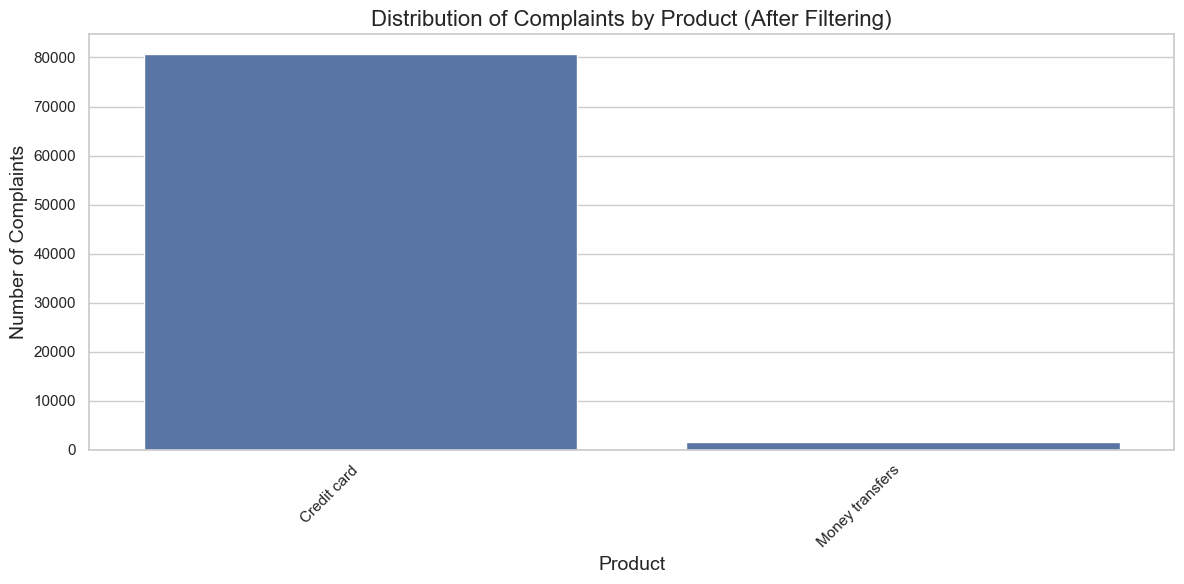


Percentage of complaints by product after filtering:
Credit card: 98.18%
Money transfers: 1.82%


In [9]:
# 3.1 Filter by product and narrative presence

# Filter to include only the five specified products
df_filtered = df[df['Product'].isin(PRODUCTS_OF_INTEREST)]

# Count before removing empty narratives
count_before = len(df_filtered)
print(f"Number of complaints for the five specified products: {count_before}")

# Remove records with empty Consumer complaint narrative fields
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].notna() & 
                          (df_filtered['Consumer complaint narrative'] != '')]

# Count after removing empty narratives
count_after = len(df_filtered)
print(f"Number of complaints after removing empty narratives: {count_after}")
print(f"Removed {count_before - count_after} records with empty narratives ({(count_before - count_after) / count_before * 100:.2f}%)")

# Check the distribution of products after filtering
plt.figure(figsize=(12, 6))
filtered_product_counts = df_filtered['Product'].value_counts()
sns.barplot(x=filtered_product_counts.index, y=filtered_product_counts.values)
plt.title('Distribution of Complaints by Product (After Filtering)', fontsize=16)
plt.xlabel('Product', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the percentage of complaints for each product after filtering
filtered_product_percentage = (filtered_product_counts / filtered_product_counts.sum()) * 100
print("\nPercentage of complaints by product after filtering:")
for product, percentage in filtered_product_percentage.items():
    print(f"{product}: {percentage:.2f}%")


## 4. Clean the Text Narratives

Now let's clean the text narratives to improve embedding quality. This may include:
1. Lowercasing text
2. Removing special characters
3. Removing boilerplate text
4. Other text normalization techniques


Examples of original vs cleaned narratives:

Example 5915676:
Original: I opened a checking and savings account on XX/XX/24 along with a credit card at Chase bank.I paid my credit card bill before even receiving a statement. When I visited the bank for the first time to w...
Cleaned: i opened a checking and savings account on xxxx24 along with a credit card at chase bank.i paid my credit card bill before even receiving a statement. when i visited the bank for the first time to wit...

Example 4034756:
Original: I went into Kay Jewelers at XXXX, XXXX XXXX, XXXX XXXX XXXX XXXX, XXXX, NY XXXX to view engagement rings. The sales person offered to run a credit check to see if I could qualify for financing and I a...
Cleaned: i went into kay jewelers at xxxx, xxxx xxxx, xxxx xxxx xxxx xxxx, xxxx, ny xxxx to view engagement rings. the sales person offered to run a credit check to see if i could qualify for financing and i a...

Example 2539601:
Original: I called Capital One to be removed as 

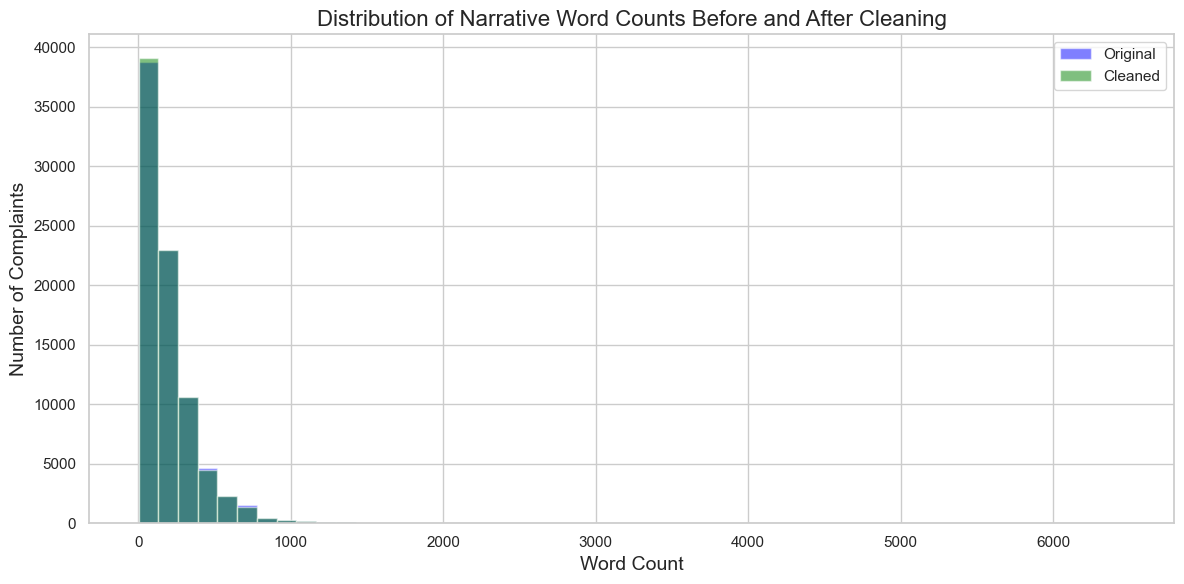

In [10]:
# 4.1 Define text cleaning functions

def clean_text(text):
    """
    Clean text by applying various preprocessing steps
    
    Args:
        text (str): The text to clean
        
    Returns:
        str: The cleaned text
    """
    if not isinstance(text, str) or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove common boilerplate phrases often found in complaint narratives
    boilerplate = [
        "i am writing to file a complaint",
        "i am writing to complain",
        "i would like to file a complaint",
        "i am submitting this complaint",
        "to whom it may concern",
        "dear sir or madam"
    ]
    
    for phrase in boilerplate:
        text = text.replace(phrase, '')
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters but keep basic punctuation for readability
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the narratives
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

# Check a few examples of original vs cleaned narratives
print("Examples of original vs cleaned narratives:")
sample_indices = df_filtered.sample(3).index
for idx in sample_indices:
    original = df_filtered.loc[idx, 'Consumer complaint narrative']
    cleaned = df_filtered.loc[idx, 'cleaned_narrative']
    
    print(f"\nExample {idx}:")
    print(f"Original: {original[:200]}..." if len(original) > 200 else f"Original: {original}")
    print(f"Cleaned: {cleaned[:200]}..." if len(cleaned) > 200 else f"Cleaned: {cleaned}")
    
# Calculate the word count for cleaned narratives
df_filtered['cleaned_word_count'] = df_filtered['cleaned_narrative'].apply(count_words)

# Compare the word count before and after cleaning
word_count_comparison = pd.DataFrame({
    'Original': df_filtered['narrative_word_count'],
    'Cleaned': df_filtered['cleaned_word_count']
})

print("\nWord count statistics before and after cleaning:")
print(word_count_comparison.describe())

# Calculate the average reduction in word count
avg_reduction = (df_filtered['narrative_word_count'] - df_filtered['cleaned_word_count']).mean()
avg_reduction_pct = avg_reduction / df_filtered['narrative_word_count'].mean() * 100
print(f"\nAverage reduction in word count: {avg_reduction:.2f} words ({avg_reduction_pct:.2f}%)")

# Plot the distribution of word counts before and after cleaning
plt.figure(figsize=(12, 6))
plt.hist(df_filtered['narrative_word_count'], bins=50, alpha=0.5, label='Original', color='blue')
plt.hist(df_filtered['cleaned_word_count'], bins=50, alpha=0.5, label='Cleaned', color='green')
plt.title('Distribution of Narrative Word Counts Before and After Cleaning', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


## 5. Save the Cleaned and Filtered Dataset

Now that we have filtered and cleaned the dataset, let's save it for use in subsequent tasks.


In [11]:
# 5.1 Save the filtered and cleaned dataset

# Create the processed data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Define the output file path
filtered_data_path = Path('../data/processed/filtered_complaints.csv')

# Select the columns to keep
columns_to_keep = [
    'Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
    'Company', 'State', 'ZIP code', 'Consumer complaint narrative',
    'cleaned_narrative', 'Company response to consumer', 'Complaint ID'
]

# Save the filtered and cleaned dataset
df_filtered[columns_to_keep].to_csv(filtered_data_path, index=False)

print(f"Filtered and cleaned dataset saved to {filtered_data_path}")
print(f"Number of records: {len(df_filtered)}")
print(f"File size: {filtered_data_path.stat().st_size / (1024 * 1024):.2f} MB")


Filtered and cleaned dataset saved to ..\data\processed\filtered_complaints.csv
Number of records: 82164
File size: 188.69 MB


## 6. Summary of Findings

In this notebook, we performed exploratory data analysis on the CFPB complaint dataset and prepared it for the RAG pipeline. Here's a summary of our findings:


In [14]:
# 6.1 Generate a summary of findings

# Calculate some final statistics for the summary
total_complaints = len(df)
filtered_complaints = len(df_filtered)
products_count = df_filtered['Product'].value_counts()
avg_narrative_length = df_filtered['cleaned_word_count'].mean()
median_narrative_length = df_filtered['cleaned_word_count'].median()
top_issues = df_filtered['Issue'].value_counts().head(5)

# Create a summary markdown string
summary = f"""
### Summary of Exploratory Data Analysis

#### Dataset Overview
- Original dataset: {total_complaints} complaints
- Filtered dataset: {filtered_complaints} complaints ({filtered_complaints/total_complaints*100:.2f}% of original)
- Time period: {df_filtered['Date received'].min()} to {df_filtered['Date received'].max()}

#### Product Distribution
"""

for product, count in products_count.items():
    summary += f"- {product}: {count} complaints ({count/filtered_complaints*100:.2f}%)\n"

summary += f"""
#### Narrative Characteristics
- Average narrative length: {avg_narrative_length:.2f} words
- Median narrative length: {median_narrative_length:.0f} words
- Narratives with fewer than 10 words: {len(df_filtered[df_filtered['cleaned_word_count'] < 10])}
- Narratives with more than 200 words: {len(df_filtered[df_filtered['cleaned_word_count'] > 200])}

#### Top 5 Issues
"""

for issue, count in top_issues.items():
    summary += f"- {issue}: {count} complaints ({count/filtered_complaints*100:.2f}%)\n"

summary += f"""
#### Data Cleaning Results
- Text cleaning reduced word count by an average of {avg_reduction:.2f} words ({avg_reduction_pct:.2f}%)
- All narratives are now lowercase with special characters removed
- Common boilerplate phrases have been removed

#### Next Steps
1. Split long narratives into chunks for better embedding
2. Generate embeddings using a suitable model
3. Index the embeddings in a vector database
4. Develop the RAG agent to query the vector database
"""

# Display the summary
from IPython.display import Markdown
Markdown(summary)



### Summary of Exploratory Data Analysis

#### Dataset Overview
- Original dataset: 9609797 complaints
- Filtered dataset: 82164 complaints (0.86% of original)
- Time period: 2015-03-19 to 2025-06-15

#### Product Distribution
- Credit card: 80667 complaints (98.18%)
- Money transfers: 1497 complaints (1.82%)

#### Narrative Characteristics
- Average narrative length: 196.90 words
- Median narrative length: 140 words
- Narratives with fewer than 10 words: 329
- Narratives with more than 200 words: 28827

#### Top 5 Issues
- Problem with a purchase shown on your statement: 14338 complaints (17.45%)
- Problem with a company's investigation into an existing problem: 7362 complaints (8.96%)
- Getting a credit card: 7253 complaints (8.83%)
- Other features, terms, or problems: 6907 complaints (8.41%)
- Fees or interest: 6688 complaints (8.14%)

#### Data Cleaning Results
- Text cleaning reduced word count by an average of 3.15 words (1.58%)
- All narratives are now lowercase with special characters removed
- Common boilerplate phrases have been removed

#### Next Steps
1. Split long narratives into chunks for better embedding
2. Generate embeddings using a suitable model
3. Index the embeddings in a vector database
4. Develop the RAG agent to query the vector database


In [15]:
# 7.1 Save the summary to a markdown file

# Create a reports directory if it doesn't exist
os.makedirs('../data/reports', exist_ok=True)

# Define the output file path
summary_path = Path('../data/reports/eda_summary.md')

# Save the summary to a markdown file
with open(summary_path, 'w') as f:
    f.write("# Exploratory Data Analysis Summary\n\n")
    f.write("## CFPB Complaint Dataset\n\n")
    f.write(summary)

print(f"Summary saved to {summary_path}")

# Print a final message
print("\nTask 1 completed successfully!")
print("The filtered and cleaned dataset is ready for Task 2: Text Chunking, Embedding, and Vector Store Indexing.")


Summary saved to ..\data\reports\eda_summary.md

Task 1 completed successfully!
The filtered and cleaned dataset is ready for Task 2: Text Chunking, Embedding, and Vector Store Indexing.
